Importación de Librerias y Funciones

In [ ]:
import joblib
import pandas as pd
from config import *
from math import sqrt
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from scipy.optimize import minimize
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import VotingRegressor, StackingRegressor, AdaBoostRegressor

Preparación de Datos

In [1]:
import joblib
from config import *
import pandas as pd
from sklearn.model_selection import train_test_split

data = pd.read_csv('../Data/test/all_data.csv')
scaler = joblib.load('../models/v3/scaler.joblib')

features = ['tipoPropiedad', 'terrenoEdificado', 
            'cantDormitorios', 'cantBanos',
            'barrioID', 'coordX', 'coordY', 
            'transporteCercano', 'saludCercana', 
            'ano', 'mes']
data_analisis = data[features]
target = data["precioUSD"]

X_train, X_test, y_train, y_test = train_test_split(data_analisis, target, train_size=0.8, random_state=33)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Preparación de Modelos

In [2]:
from math import sqrt
from xgboost import XGBRegressor

xgb = XGBRegressor(n_estimators=500, learning_rate=0.0835, max_depth=7, random_state=33, objective='reg:squarederror')
xgb.fit(X_train_scaled, y_train)

voting = joblib.load('../models/v3/voting.joblib')
stacking = joblib.load('../models/v3/stacking.joblib')

Predicciones Iniciales

In [3]:
voting_pred = voting.predict(X_test_scaled)
stacking_pred = stacking.predict(X_test_scaled)
xgb_pred = xgb.predict(X_test_scaled)

Testeo de Modelos

Model		RMSE		R2
Voting: 	36375.93277964125	0.8003255472096124
Stacking: 	36653.77662619536	0.7972636219819653
XGB: 		35134.264824433		0.8137244018860634



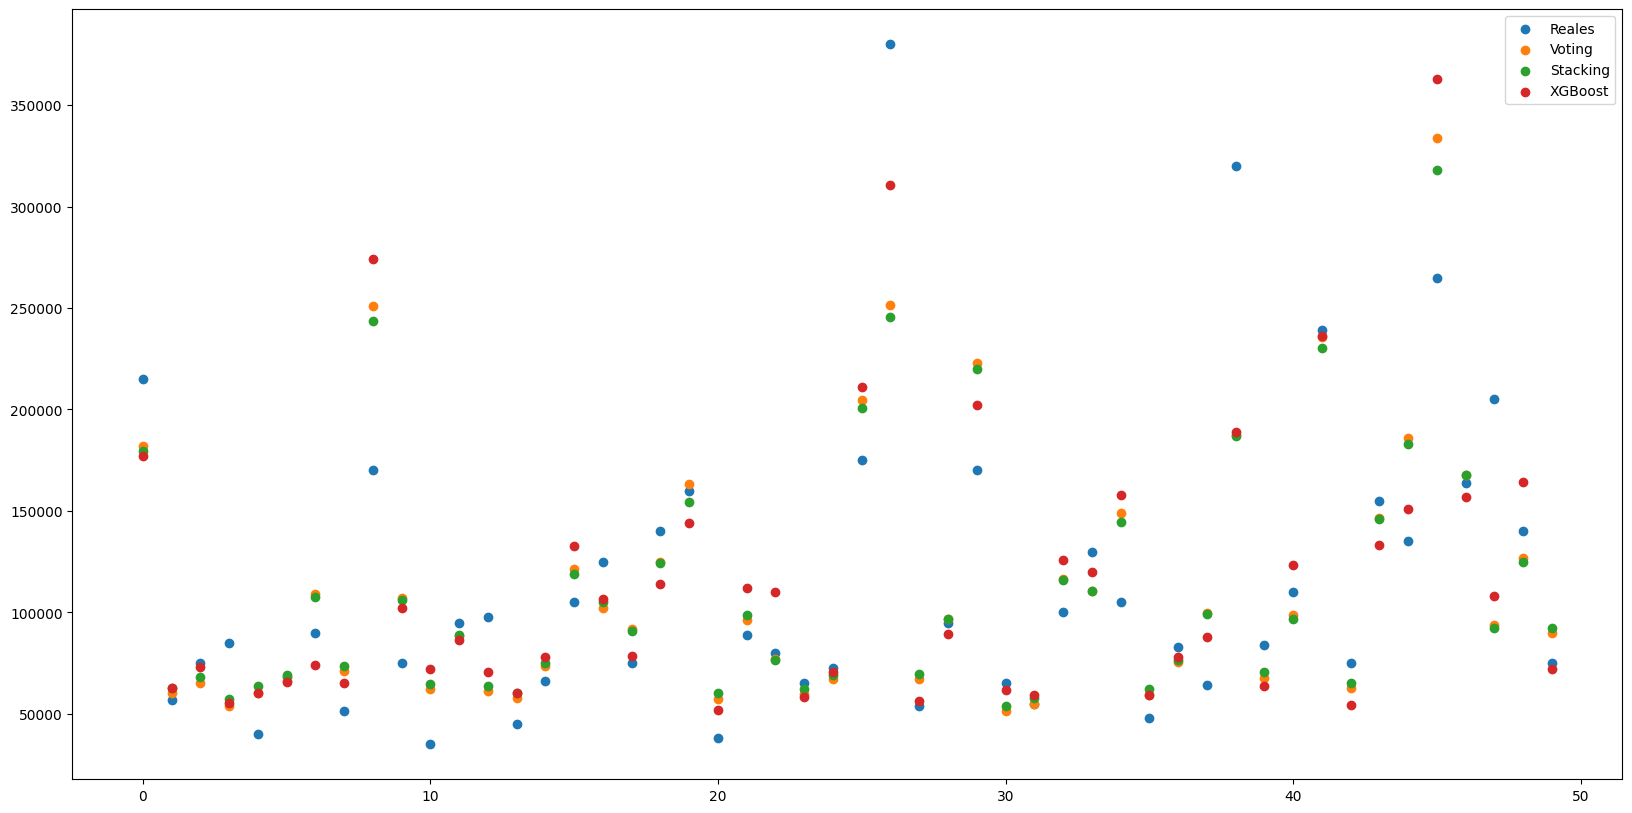

In [9]:
# Test accuracy
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

print("Model\t\tRMSE\t\tR2")
print(f"Voting: \t{sqrt(mean_squared_error(y_test, voting_pred))}\t{r2_score(y_test, voting_pred)}")
print(f"Stacking: \t{sqrt(mean_squared_error(y_test, stacking_pred))}\t{r2_score(y_test, stacking_pred)}")
print(f"XGB: \t\t{sqrt(mean_squared_error(y_test, xgb_pred))}\t\t{r2_score(y_test, xgb_pred)}\n")

# Test with cross validation
"""print("Model\t\tCross validation scores")
print("Voting: \t", cross_val_score(voting, X_train_scaled, y_train, cv=5, scoring='r2'))
print("Stacking: \t", cross_val_score(stacking, X_train_scaled, y_train, cv=5, scoring='r2'))
print("XGBoost: \t", cross_val_score(xgb, X_train_scaled, y_train, cv=5, scoring='r2'), "\n")"""

# Graficar y_test, predicciones de cada modelo y predicciones del ensamble
plt.figure(figsize=(20, 10))
plt.scatter(range(50), y_test.values[:50], label='Reales')
plt.scatter(range(50), voting_pred[:50], label='Voting')
plt.scatter(range(50), stacking_pred[:50], label='Stacking')
plt.scatter(range(50), xgb_pred[:50], label='XGBoost')
plt.legend()
plt.show()

Modelo Corrector 0: Ensamble de Ensamble

In [5]:
# Buscar pesos optimos para el voting_c
from sklearn.ensemble import VotingRegressor, StackingRegressor
import joblib
from scipy.optimize import minimize
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error

unfitted_models = [
  ("voting", joblib.load('../models/unfitted_voting.joblib')),
  ("stacking", joblib.load('../models/unfitted_stacking.joblib')),
  ("xgb", XGBRegressor(n_estimators=500, learning_rate=0.0835, max_depth=7, random_state=33, objective='reg:squarederror'))
]

def objective(weights):
    weights_dict = dict(zip(unfitted_models, weights))
    weighted_ensemble = VotingRegressor(estimators=unfitted_models, weights=list(weights_dict.values()))
    weighted_ensemble.fit(X_train, y_train)
    r2 = cross_val_score(weighted_ensemble, X_train, y_train, cv=5, scoring='r2').mean()
    print(f"r2 = {r2}, weights = {weights}")
    return -r2
  
print("Calculando pesos optimos...")
#initial_weights = [ 0.56869447, -0.09622239,  0.52752792]
#constraints = ({'type': 'eq', 'fun': lambda w: 1 - sum(w)})
#result = minimize(objective, initial_weights, constraints=constraints)
optimal_weights = [ 0.56869447, -0.09622239,  0.52752792] #result.x
#print(f"Optimal weights: {optimal_weights}")

# Construir el voting_c con los pesos optimos
print("Creando Voting...")
voting_c = VotingRegressor(estimators=list(unfitted_models), weights=list(optimal_weights))
voting_c.fit(X_train, y_train)
voting_c_pred = voting_c.predict(X_test)
print("Model\t\tRMSE\t\t\tR2")
print(f"Voting C: \t{sqrt(mean_squared_error(y_test, voting_c_pred))}\t{r2_score(y_test, voting_c_pred)}")

"""cv_s = cross_val_score(voting_c, X_train, y_train, cv=5, scoring='r2')
print("Model\t\tCross validation scores")
print("Voting C:\t", cv_s)
print(f"Mean: {cv_s.mean()} \n")"""

Calculando pesos optimos...
Creando Voting...
Model		RMSE			R2
Voting C: 	34879.8172152836	0.8164127035399436


'cv_s = cross_val_score(voting_c, X_train, y_train, cv=5, scoring=\'r2\')\nprint("Model\t\tCross validation scores")\nprint("Voting C:\t", cv_s)\nprint(f"Mean: {cv_s.mean()} \n")'

In [6]:
unfitted_models = [
  ("voting", joblib.load('../models/unfitted_voting.joblib')),
  ("xgb", XGBRegressor(n_estimators=500, learning_rate=0.0835, max_depth=7, random_state=33, objective='reg:squarederror'))
]

print("Creando Stacking...")
stacking_c = StackingRegressor(estimators=list(unfitted_models))
stacking_c.fit(X_train, y_train)

stacking_c_pred = stacking_c.predict(X_test)
print("Model\t\tRMSE\t\t\tR2")
print(f"Stacking C: \t{sqrt(mean_squared_error(y_test, stacking_c_pred))}\t{r2_score(y_test, stacking_c_pred)}\n")

# Test accuracy
"""print("Model\t\tCross validation scores")
cv_s = cross_val_score(stacking_c, X_train, y_train, cv=5, scoring='r2')
print("Stacking C:\t", cv_s)
print(f"Mean: {cv_s.mean()} \n")"""

Creando Stacking...
Model		RMSE			R2
Stacking C: 	34823.09770418308	0.8170092958411872



'print("Model\t\tCross validation scores")\ncv_s = cross_val_score(stacking_c, X_train, y_train, cv=5, scoring=\'r2\')\nprint("Stacking C:\t", cv_s)\nprint(f"Mean: {cv_s.mean()} \n")'

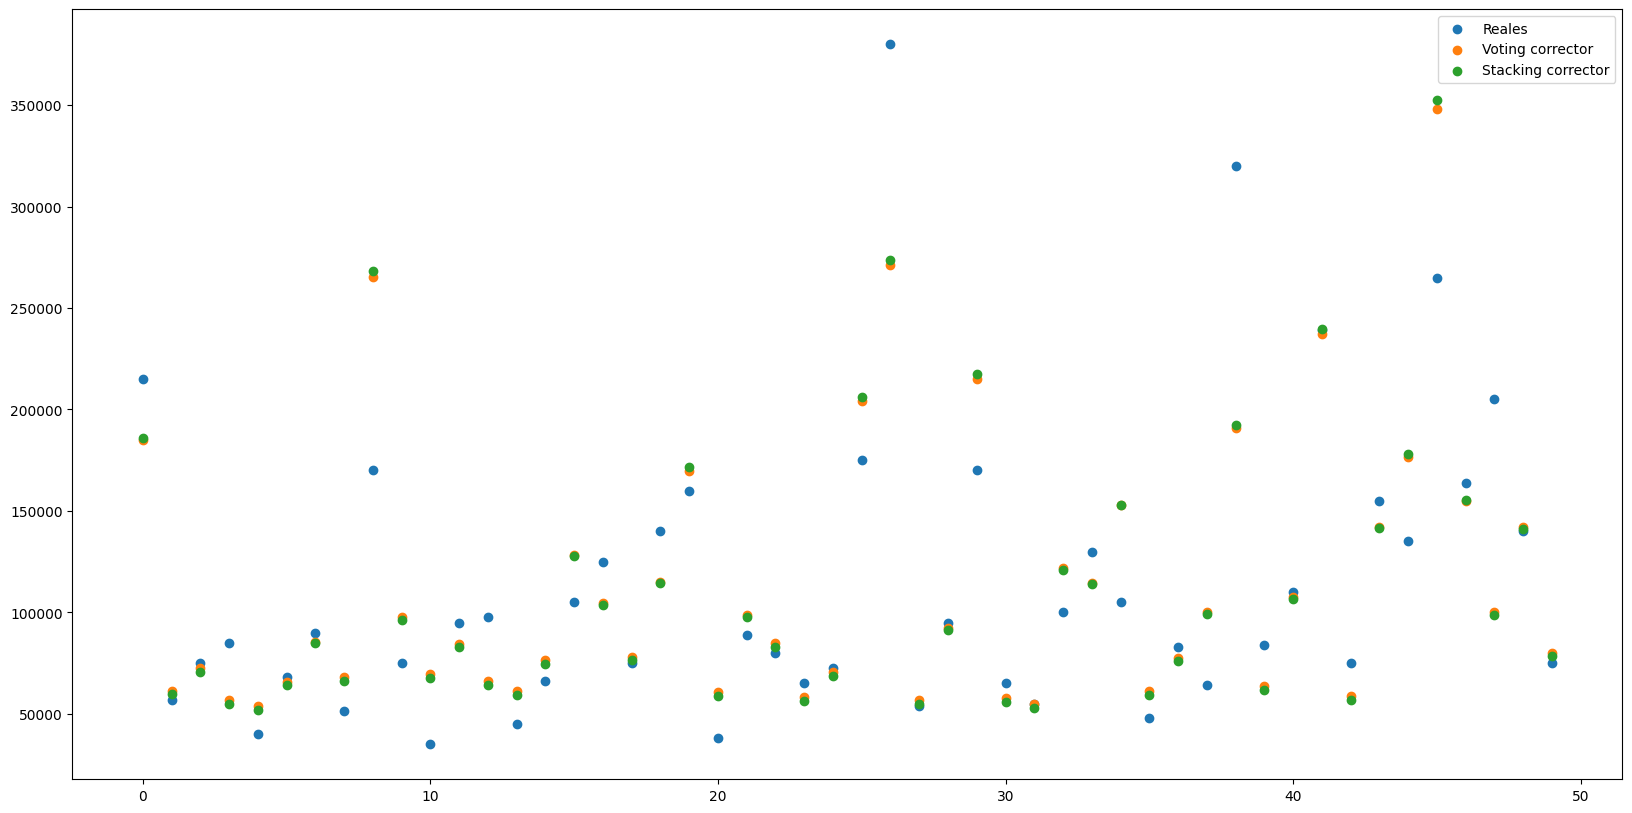

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.scatter(range(50), y_test.values[:50], label='Reales')
plt.scatter(range(50), voting_c_pred[:50], label='Voting corrector')
plt.scatter(range(50), stacking_c_pred[:50], label='Stacking corrector')
plt.legend()
plt.show()

R^2 fit_line: 0.8171171924664385
RMSE fit_line: 34812.82983632559


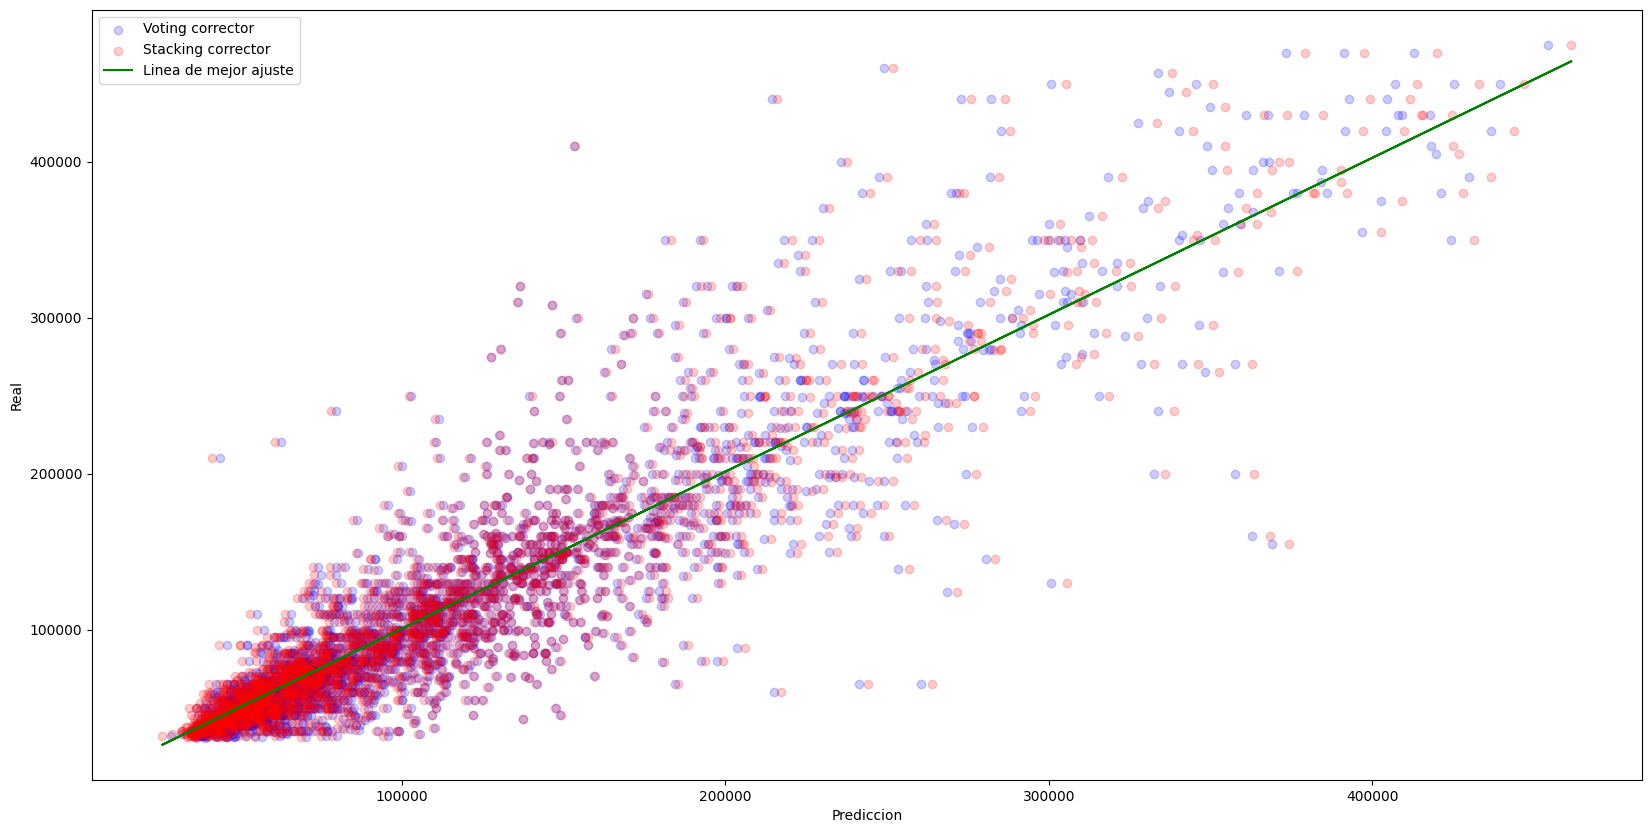

In [10]:
import numpy as np

# Calcular la línea de mejor ajuste
fit_line = np.polyfit(stacking_c_pred, y_test, 1)
fit_line_equation = np.poly1d(fit_line)

# Calcular predicciones según la línea de mejor ajuste
fit_line_predictions = fit_line_equation(stacking_c_pred)

fit_line_r2 = r2_score(y_test, fit_line_predictions)
fit_line_rmse = np.sqrt(mean_squared_error(y_test, fit_line_predictions))

print(f"R^2 fit_line: {fit_line_r2}")
print(f"RMSE fit_line: {fit_line_rmse}")

#plot scatter plot
plt.figure(figsize=(20, 10))
plt.scatter(voting_c_pred, y_test, alpha=0.2, c='blue', label='Voting corrector')
plt.scatter(stacking_c_pred, y_test, alpha=0.2, c='red', label='Stacking corrector')
plt.plot(stacking_c_pred, fit_line_predictions, c='green', label='Linea de mejor ajuste')
plt.legend()
plt.xlabel('Prediccion')
plt.ylabel('Real')
plt.show()

In [4]:
import joblib
from sklearn.ensemble import VotingRegressor
from sklearn.model_selection import cross_val_score
features = ['tipoPropiedad', 'terrenoEdificado', 
            'cantDormitorios', 'cantBanos',
            'barrioID', 'coordX', 'coordY', 
            'transporteCercano', 'saludCercana', 
            'ano', 'mes']
data_analisis = data[features]
target = data["precioUSD"]

scaled_data_analisis = scaler.transform(data_analisis)

print("Creando Voting...")
voting_c = VotingRegressor(estimators=[
  ("voting", joblib.load('../models/unfitted_voting.joblib')),
  ("stacking", joblib.load('../models/unfitted_stacking.joblib'))])
print("Entrenando Voting...")
voting_c.fit(scaled_data_analisis, target)
print("Calculando cross validation scores...")
print(f"Voting c r2: {cross_val_score(voting_c, scaled_data_analisis, target, cv=5, scoring='r2').mean()}")

Calculando cross validation scores...


Voting c r2: 0.6709210354586785


Modelo corrector: Prediccion directa

XGBoost corrector: 	 0.803429364360451 	 34508.0611512247
AdaBoost corrector: 	 0.8055823759291932 	 34505.64740975288


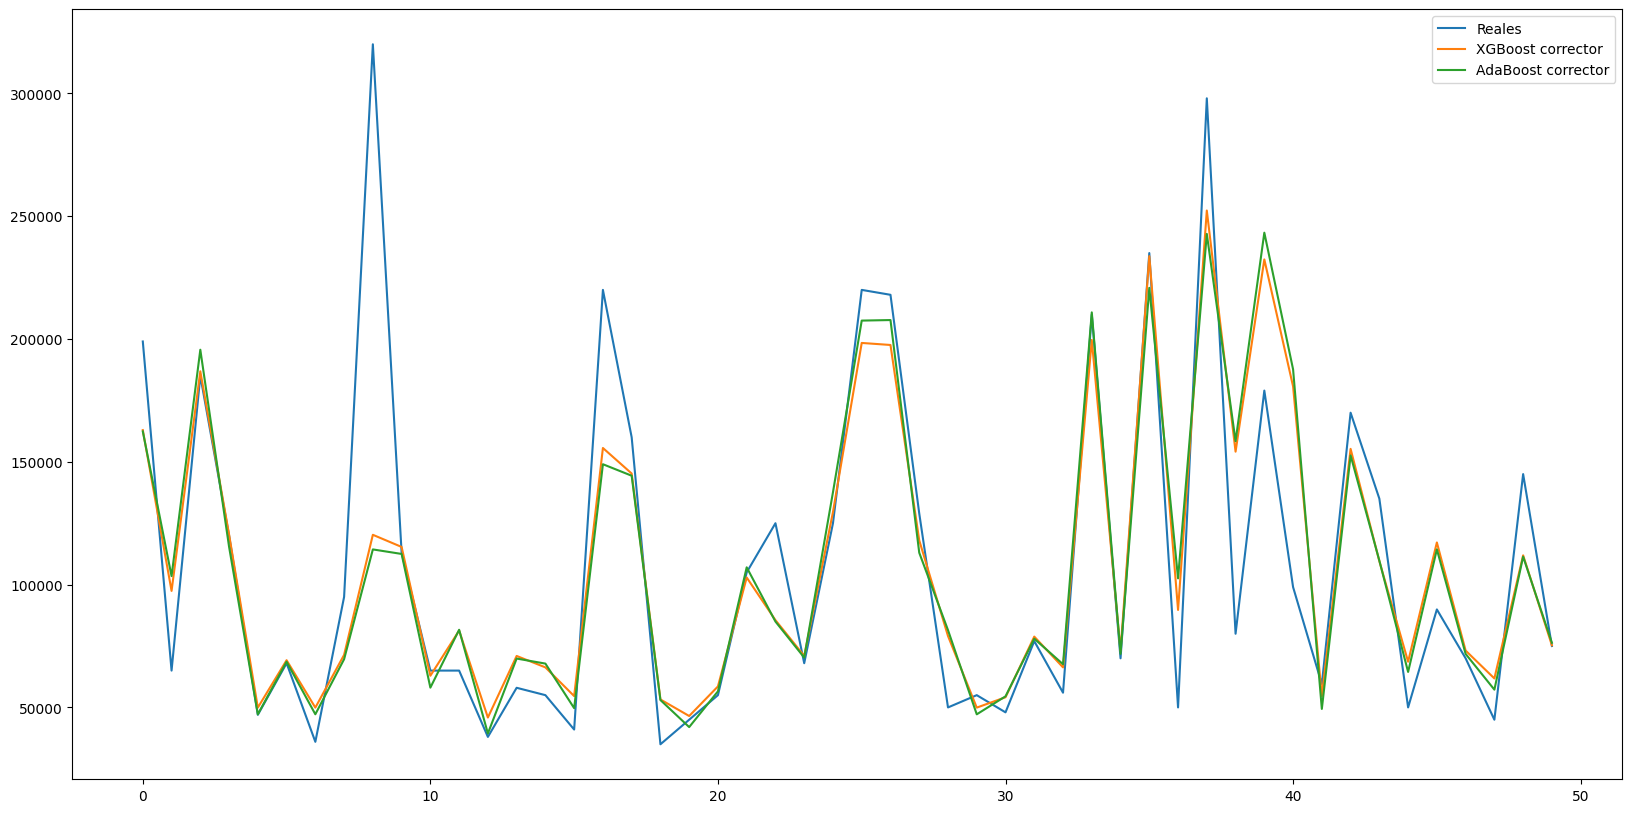

In [121]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler

# Preparacion de datos: X_test + predicciones de los modelos
X_pred = pd.DataFrame(X_test)
X_pred['voting'] = voting_pred
X_pred['stacking'] = stacking_pred
X_pred['xgb'] = xgb_pred

# Train test split
X_train_pred, X_test_pred, y_train_pred, y_test_pred = train_test_split(X_pred, y_test, train_size=0.7, random_state=33)

scaler_c = StandardScaler()
X_train_pred_scaled = scaler_c.fit_transform(X_train_pred)
X_test_pred_scaled = scaler_c.transform(X_test_pred)

# Modelo XGBoost
xgbc = XGBRegressor(n_estimators=110, learning_rate=0.032, max_depth=3, random_state=33, objective='reg:squarederror')
xgbc.fit(X_train_pred_scaled, y_train_pred)
xgbc_preds = xgbc.predict(X_test_pred_scaled)

r2 = cross_val_score(xgbc, X_train_pred_scaled, y_train_pred, cv=5, scoring='r2').mean()
rmse = sqrt(mean_squared_error(y_test_pred, xgbc_preds))

print(f"XGBoost corrector: \t {r2} \t {rmse}")

# Modelo AdaBoost
ada = AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=5), n_estimators=100, learning_rate=0.025, random_state=33)
ada.fit(X_train_pred_scaled, y_train_pred)
ada_preds = ada.predict(X_test_pred_scaled)

r2 = cross_val_score(ada, X_train_pred_scaled, y_train_pred, cv=5, scoring='r2').mean()
rmse = sqrt(mean_squared_error(y_test_pred, ada_preds))

print(f"AdaBoost corrector: \t {r2} \t {rmse}")

# Graficar y_test_pred, predicciones de cada modelo y predicciones del ensamble
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.plot(y_test_pred.values[:50], label='Reales')
plt.plot(xgbc_preds[:50], label='XGBoost corrector')
plt.plot(ada_preds[:50], label='AdaBoost corrector')
plt.legend()
plt.show()